# SYN Attack Detection using RNNs

Links 
1. <a href="https://data.mendeley.com/datasets/mfnn9bh42m/1#file-ba7d3a46-1dc3-452e-aeac-26d909389b29">Dataset</a>
2. <a href="https://www.sciencedirect.com/science/article/pii/S2352340920310817#bib0005">Paper</a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/mfnn9bh42m-1.zip .

In [ ]:
!unzip mfnn9bh42m-1.zip

Archive:  mfnn9bh42m-1.zip
  inflating: BOUN_DDoS dataset.zip   


In [ ]:
!unzip BOUN_DDoS\ dataset.zip

Archive:  BOUN_DDoS dataset.zip
   creating: BOUN_DDoS dataset/
  inflating: BOUN_DDoS dataset/BOUN_TCP_Anon.csv  
  inflating: BOUN_DDoS dataset/BOUN_UDP_Anon.csv  


In [ ]:
file1 = "BOUN_DDoS dataset/BOUN_TCP_Anon.csv"
file2 = "BOUN_DDoS dataset/BOUN_UDP_Anon.csv" 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

In [ ]:
data1 = pd.read_csv(file1)
data1.head()

,Time,Frame Number,Frame_length,Source_ip,Destination_IP,Source_Port,Destination_Port,SYN,ACK,RST,TTL,TCP_Protocol
0,0.000000,1,64,10.50.197.71,10.50.192.199,49543.0,443.0,Not set,Set,Not set,127,TCP
1,0.000002,2,2978,10.50.192.199,10.50.197.71,443.0,49543.0,Not set,Set,Not set,127,TCP
2,0.000040,3,64,10.50.197.71,10.50.192.199,49543.0,443.0,Not set,Set,Not set,127,TCP
3,0.000042,4,4438,10.50.192.199,10.50.197.71,443.0,49543.0,Not set,Set,Not set,127,TCP
4,0.000053,5,64,10.50.197.71,10.50.192.199,49543.0,443.0,Not set,Set,Not set,127,TCP


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335605 entries, 0 to 9335604
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Time              float64
 1   Frame Number      int64  
 2   Frame_length      int64  
 3   Source_ip         object 
 4   Destination_IP    object 
 5   Source_Port       float64
 6   Destination_Port  float64
 7   SYN               object 
 8   ACK               object 
 9   RST               object 
 10  TTL               object 
 11  TCP_Protocol      object 
dtypes: float64(3), int64(2), object(7)
memory usage: 854.7+ MB


In [ ]:
data1.isnull().sum()

Time                      0
Frame Number              0
Frame_length              0
Source_ip                 0
Destination_IP            0
Source_Port         3244465
Destination_Port    3244465
SYN                 3244503
ACK                 3244503
RST                 3244503
TTL                   33241
TCP_Protocol          33241
dtype: int64

In [ ]:
data1.nunique()

Time                8889522
Frame Number        9335605
Frame_length           8691
Source_ip            137521
Destination_IP        14630
Source_Port           61252
Destination_Port      24339
SYN                       2
ACK                       2
RST                       2
TTL                     573
TCP_Protocol              9
dtype: int64

## Checking For Boundaries

A experimental check to find the places where the traffic is relaxed (possible end of attacks)

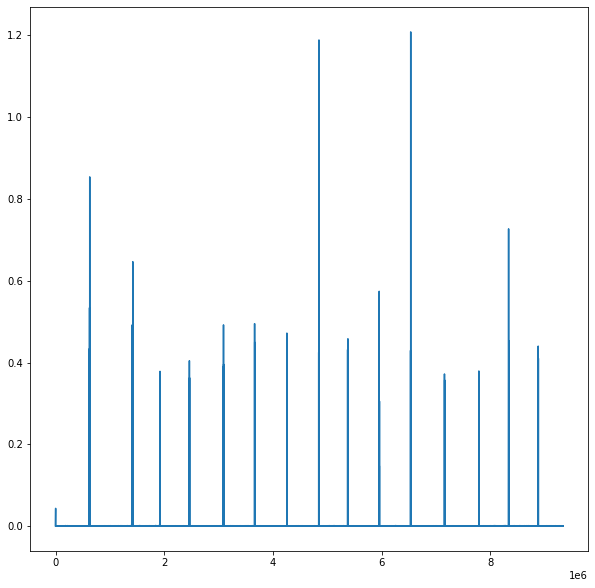

In [ ]:
times = data1["Time"]
last = times[0]
diffs = []
for i in times[1:] :
  diffs.append(i-last)
  last = i

plt.plot(list(range(len(diffs))), diffs)

## Dataset Generation

Filling NA and replacing the string with appropriate numbers

In [ ]:
dataset = data1[["Time","SYN","ACK","RST","Frame_length"]]
dataset["SYN"] = dataset["SYN"].fillna(0)
dataset["ACK"] = dataset["ACK"].fillna(0)
dataset["RST"] = dataset["RST"].fillna(0)
dataset["SYN"] = dataset["SYN"].replace(['Set','Not set'],[1,0])
dataset["ACK"] = dataset["ACK"].replace(['Set','Not set'],[1,0])
dataset["RST"] = dataset["RST"].replace(['Set','Not set'],[1,0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
dataset.head()

,Time,SYN,ACK,RST,Frame_length
0,0.000000,0,1,0,64
1,0.000002,0,1,0,2978
2,0.000040,0,1,0,64
3,0.000042,0,1,0,4438
4,0.000053,0,1,0,64


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9335605 entries, 0 to 9335604
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Time          float64
 1   SYN           int64  
 2   ACK           int64  
 3   RST           int64  
 4   Frame_length  int64  
dtypes: float64(1), int64(4)
memory usage: 356.1 MB


In [ ]:
dataset.isnull().sum()

Time            0
SYN             0
ACK             0
RST             0
Frame_length    0
dtype: int64

# Plan Of Action

I plan to create a list of slices of the dataset, with each slice being attributed to one of the classes :  "Attack", "No Attack". Then I'll pass this time-series slice and the target to the model.

So I will take a fixed size out of these slices and provide them as input to the RNN where slice of slice = input, target = attack T/F

Feature I plan to use : 
1. Time (adjusted to be difference from start of slice)
2. SYN
3. ACK
4. RST
5. Frame_length


The attack timings are provided in the attached article. 
I am not including IP. Trying to focus on packets received to predict malicious rate.

In [ ]:
attack_time = [
               [80.22269, 102.20233],
               [180.17426, 203.08441],
               [279.97402, 301.79111],
               [380.10981, 402.35755]
]

print(min(dataset.Time), max(dataset.Time))

0.0 482.66291399999994


### Creating time slices for filtering first

In [ ]:
curr = min(dataset.Time)
time_slices = []
for i in attack_time : 
  time_slices.append([curr, i[0]])
  time_slices.append(i)
  curr = i[1]
time_slices.append([curr, max(dataset.Time)])
print(time_slices)

[[0.0, 80.22269], [80.22269, 102.20233], [102.20233, 180.17426], [180.17426, 203.08441], [203.08441, 279.97402], [279.97402, 301.79111], [301.79111, 380.10981], [380.10981, 402.35755], [402.35755, 482.66291399999994]]


### The real slices generation and assigning labels

1 - Attack <br />
0 - Not Attack <br />

In [ ]:
slices = []
vals = []

for i in time_slices :
  slices.append(dataset[(dataset["Time"]>=i[0]) & (dataset["Time"]<=i[1])])
  if i in attack_time : 
    vals.append(1)
  else :
    vals.append(0)

We get the minimum length of a slice, we will need it for batch-wise data generation for our time series

In [ ]:
min_len = len(dataset)
for i in slices : 
  min_len = min(min_len, len(i))
print(min_len)

388232


# Checkpoint 

To prevent RAM overload

In [ ]:
import pickle

with open('drive/MyDrive/TCP_Slices.pickle', 'wb') as handle:
    pickle.dump((time_slices, slices, vals), handle, protocol=pickle.HIGHEST_PROTOCOL)

## Resume execution here

In [6]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

plt.rcParams["figure.figsize"] = (10,10)

with open('drive/MyDrive/TCP_Slices.pickle', 'rb') as handle:
  f =  pickle.load(handle)
  time_slices, slices, vals  = f

num_x_signals = 4
num_y_signals = 1

In [7]:
def batch_generator(batch_size=1,  sequence_length=1000):
    while True:
      x_batch = []
      y_batch = []
      for i in range(batch_size):
        ind = random.randint(0, len(slices)-1)
        x = slices[ind]
        idx = random.randint(0,len(x)-sequence_length-1)
        x_batch.append(np.array(x.drop(["Time"], axis=1)[idx : idx+sequence_length]))
        y_batch.append(np.array([vals[ind]]))
      yield (np.array(x_batch), np.array(y_batch))
  
  
train_batch_size = 30
val_batch_size = 5
sequence_length = 1000

train_generator = batch_generator(batch_size=train_batch_size, sequence_length=sequence_length)
val_generator = batch_generator(batch_size=val_batch_size, sequence_length=sequence_length)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, input_shape = (sequence_length, num_x_signals, ), return_sequences = True), 
  tf.keras.layers.Dense(256),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer = "adam", 
    metrics = ["accuracy"],
    loss = "binary_crossentropy"
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1000, 128)         68096     
_________________________________________________________________
dense_3 (Dense)              (None, 1000, 256)         33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1000, 128)         32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1000, 1)           129       
Total params: 134,145
Trainable params: 134,145
Non-trainable params: 0
_________________________________________________________________


In [10]:
epochs = 50
steps_per_epoch = 20


model.fit_generator(
    generator = train_generator,
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    validation_data = next(val_generator)
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
20/20 [==============================] - 6s 324ms/step - loss: 0.0383 - accuracy: 0.9867 - val_loss: 0.0937 - val_accuracy: 0.9598
Epoch 2/50
20/20 [==============================] - 7s 342ms/step - loss: 0.0489 - accuracy: 0.9797 - val_loss: 0.0773 - val_accuracy: 0.9630
Epoch 3/50
20/20 [==============================] - 7s 334ms/step - loss: 0.0864 - accuracy: 0.9684 - val_loss: 0.2088 - val_accuracy: 0.9166
Epoch 4/50
20/20 [==============================] - 7s 340ms/step - loss: 0.0750 - accuracy: 0.9712 - val_loss: 0.0795 - val_accuracy: 0.9552
Epoch 5/50
20/20 [==============================] - 7s 332ms/step - loss: 0.0429 - accuracy: 0.9839 - val_loss: 0.0724 - val_accuracy: 0.9638
Epoch 6/50
20/20 [==============================] - 7s 347ms/step - loss: 0.0388 - accuracy: 0.9854 - val_loss: 0.0781 - val_accuracy: 0.9562
Epoch 7/50
20/20 [==============================] - 6s 320ms/step - loss: 0.0385 - accuracy: 0.9866 - val_loss: 0.0810 - val_accuracy: 0.9608
Epoch 

# Conclusion

The above model takes a sequence of 1000 rows as an input and returns if the system is under attack or not with 95.44% accuracy. We can be attach it to a real server and pass the last 1000 wireshark logs of the server to it and it will automatically close down the server if needed.